# Reinforcement Learning Experiments - Luan Nguyen

**Student:** Luan Nguyen
**Assignemnt:** Reinforcement Learning: Environment & Parameter Experiments
**Due date:** Sunday, Nov 16, 2025

>>> Note: I used AI to help make the code more modular for each experiments. All analysis, interpretations, and reflections are my own work.

In [ ]:
# Import required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import copy

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Reinforcement_Learning_V2 notebook baseline configs

The baseline setup uses a 5×5 grid with:
- Start: (0, 0)
- Goal: (4, 4)
- Obstacles: [(1, 1), (2, 2), (3, 3)]
- Reward: +10 for goal, -10 for obstacles, -1 for steps
- Hyperparameters: 
    - alpha=0.1
    - gamma=0.9
    - epsilon=0.2
    - episodes=500

# Reusable components for each experiment

>>> Note: AI was used for this section to make the components more modular for interpretation and reusability. Source code belongs to the original notebook given in this assignment.

In [ ]:
# Reusable Q-Learning implementation
def create_environment(grid_size, start, goal, obstacles):
    """Create environment configuration"""
    return {
        'grid_size': grid_size,
        'start': start,
        'goal': goal,
        'obstacles': obstacles
    }

def get_reward(state, goal, obstacles, step_reward=-1, obstacle_penalty=-10, goal_reward=10):
    """Reward function with configurable parameters"""
    if state == goal:
        return goal_reward
    elif state in obstacles:
        return obstacle_penalty
    else:
        return step_reward

def get_next_state(state, action, grid_size):
    """Get next state after taking action"""
    next_state = (state[0] + action[0], state[1] + action[1])
    if 0 <= next_state[0] < grid_size and 0 <= next_state[1] < grid_size:
        return next_state
    else:
        return state  # Stay in place if move is out of bounds

def train_q_learning(env, alpha=0.1, gamma=0.9, epsilon=0.2, episodes=500, 
                     step_reward=-1, obstacle_penalty=-10, goal_reward=10,
                     epsilon_decay=None, dynamic_goal=False):
    """
    Train  agent with configurable parameters
    
    Returns:
        q_table, 
        cumulative_rewards, 
        episode_lengths, 
        exploration_counts, 
        policy_changes, epsilon_values
    """
    grid_size = env['grid_size']
    start = env['start']
    goal = env['goal']
    obstacles = env['obstacles']
    
    # Actions (Up, Down, Left, Right)
    actions = {
        0: (-1, 0),  # Up
        1: (1, 0),   # Down
        2: (0, -1),  # Left
        3: (0, 1)    # Right
    }
    
    # Initialize Q-table
    q_table = np.zeros((grid_size, grid_size, len(actions)))
    
    # Metrics storage
    cumulative_rewards = []
    episode_lengths = []
    exploration_counts = []
    policy_changes = []
    epsilon_values = []
    
    current_epsilon = epsilon
    
    for episode in range(episodes):
        # Dynamic goal: randomize goal each episode
        if dynamic_goal:
            current_goal = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
            while current_goal in obstacles or current_goal == start:
                current_goal = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        else:
            current_goal = goal
        
        state = start
        episode_reward = 0
        steps = 0
        explore_count = 0
        exploit_count = 0
        policy_change_count = 0
        previous_policy = np.copy(q_table)
        
        while state != current_goal:
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < current_epsilon:
                action_idx = random.choice(list(actions.keys()))
                explore_count += 1
            else:
                action_idx = np.argmax(q_table[state[0], state[1]])
                exploit_count += 1
            
            # Take action and observe reward
            action = actions[action_idx]
            next_state = get_next_state(state, action, grid_size)
            reward = get_reward(next_state, current_goal, obstacles, 
                              step_reward, obstacle_penalty, goal_reward)
            
            # Update Q-value
            old_value = q_table[state[0], state[1], action_idx]
            next_max = np.max(q_table[next_state[0], next_state[1]])
            q_table[state[0], state[1], action_idx] = old_value + alpha * (
                reward + gamma * next_max - old_value)
            
            # Move to next state
            episode_reward += reward
            steps += 1
            state = next_state
        
        # Record policy changes
        for x in range(grid_size):
            for y in range(grid_size):
                if np.argmax(previous_policy[x, y]) != np.argmax(q_table[x, y]):
                    policy_change_count += 1
        
        # Store metrics
        cumulative_rewards.append(episode_reward)
        episode_lengths.append(steps)
        exploration_counts.append((explore_count, exploit_count))
        policy_changes.append(policy_change_count)
        epsilon_values.append(current_epsilon)
        
        # Epsilon decay
        if epsilon_decay is not None:
            current_epsilon *= epsilon_decay
    
    return (q_table, cumulative_rewards, episode_lengths, exploration_counts, 
            policy_changes, epsilon_values)

def plot_experiment_metrics(cumulative_rewards, episode_lengths, exploration_counts, 
                            policy_changes, title_prefix="", baseline_data=None):
    """Plot all metrics with optional baseline comparison"""
    explore_ratios = [explore / (explore + exploit) if (explore + exploit) > 0 else 0 
                     for explore, exploit in exploration_counts]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix}Learning Metrics', fontsize=16, fontweight='bold')
    
    # Cumulative Rewards
    axes[0, 0].plot(cumulative_rewards, label='Experiment', linewidth=2)
    if baseline_data is not None:
        axes[0, 0].plot(baseline_data['rewards'], label='Baseline', 
                       linestyle='--', alpha=0.7, linewidth=2)
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Cumulative Reward')
    axes[0, 0].set_title('Cumulative Reward per Episode')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Episode Length
    axes[0, 1].plot(episode_lengths, label='Experiment', linewidth=2)
    if baseline_data is not None:
        axes[0, 1].plot(baseline_data['lengths'], label='Baseline', 
                       linestyle='--', alpha=0.7, linewidth=2)
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Episode Length (Steps)')
    axes[0, 1].set_title('Steps per Episode')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Exploration Rate
    axes[1, 0].plot(explore_ratios, label='Experiment', linewidth=2)
    if baseline_data is not None:
        baseline_ratios = [e/(e+x) if (e+x) > 0 else 0 
                          for e, x in baseline_data['exploration']]
        axes[1, 0].plot(baseline_ratios, label='Baseline', 
                       linestyle='--', alpha=0.7, linewidth=2)
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Exploration Rate')
    axes[1, 0].set_title('Exploration vs. Exploitation Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Policy Stability
    axes[1, 1].plot(policy_changes, label='Experiment', linewidth=2)
    if baseline_data is not None:
        axes[1, 1].plot(baseline_data['policy'], label='Baseline', 
                       linestyle='--', alpha=0.7, linewidth=2)
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Policy Changes')
    axes[1, 1].set_title('Policy Stability Over Time')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_policy(q_table, env, title="Learned Policy"):
    """Visualize the learned policy as a grid"""
    grid_size = env['grid_size']
    start = env['start']
    goal = env['goal']
    obstacles = env['obstacles']
    
    arrow = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    policy = np.full((grid_size, grid_size), '·', dtype=object)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == goal:
                policy[x, y] = 'G'
                ax.text(y, x, 'G', ha='center', va='center', 
                       color='green', fontsize=20, fontweight='bold')
            elif (x, y) in obstacles:
                policy[x, y] = 'X'
                ax.text(y, x, 'X', ha='center', va='center', 
                       color='red', fontsize=20, fontweight='bold')
            elif (x, y) == start:
                policy[x, y] = 'S'
                ax.text(y, x, 'S', ha='center', va='center', 
                       color='blue', fontsize=20, fontweight='bold')
            else:
                best_a = np.argmax(q_table[x, y])
                policy[x, y] = arrow[best_a]
                max_q = np.max(q_table[x, y])
                intensity = max(0, min(1, (max_q + 10) / 20))  # Normalize for color
                ax.text(y, x, arrow[best_a], ha='center', va='center', 
                       color=(0, 0, 0, intensity), fontsize=15)
    
    ax.set_xticks(np.arange(-0.5, grid_size, 1))
    ax.set_yticks(np.arange(-0.5, grid_size, 1))
    ax.grid(color='gray', linewidth=1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return policy


In [ ]:
# Run baseline configuration 
baseline_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 3)]
)

baseline_q, baseline_rewards, baseline_lengths, baseline_exploration, baseline_policy, _ = train_q_learning(
    baseline_env, episodes=500
)

print("Baseline results:")
print(f"Final average reward (last 50 episodes): {np.mean(baseline_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(baseline_lengths[-50:]):.2f}")


Baseline results:
Final average reward (last 50 episodes): 0.06
Final average episode length (last 50 episodes): 9.50


## 5. Adding More Obstacles

Place additional obstacles in the grid-world (e.g., increase obstacle count to 5 or 6) to observe how the agent adapts to navigate a more challenging environment 
with more negative rewards.


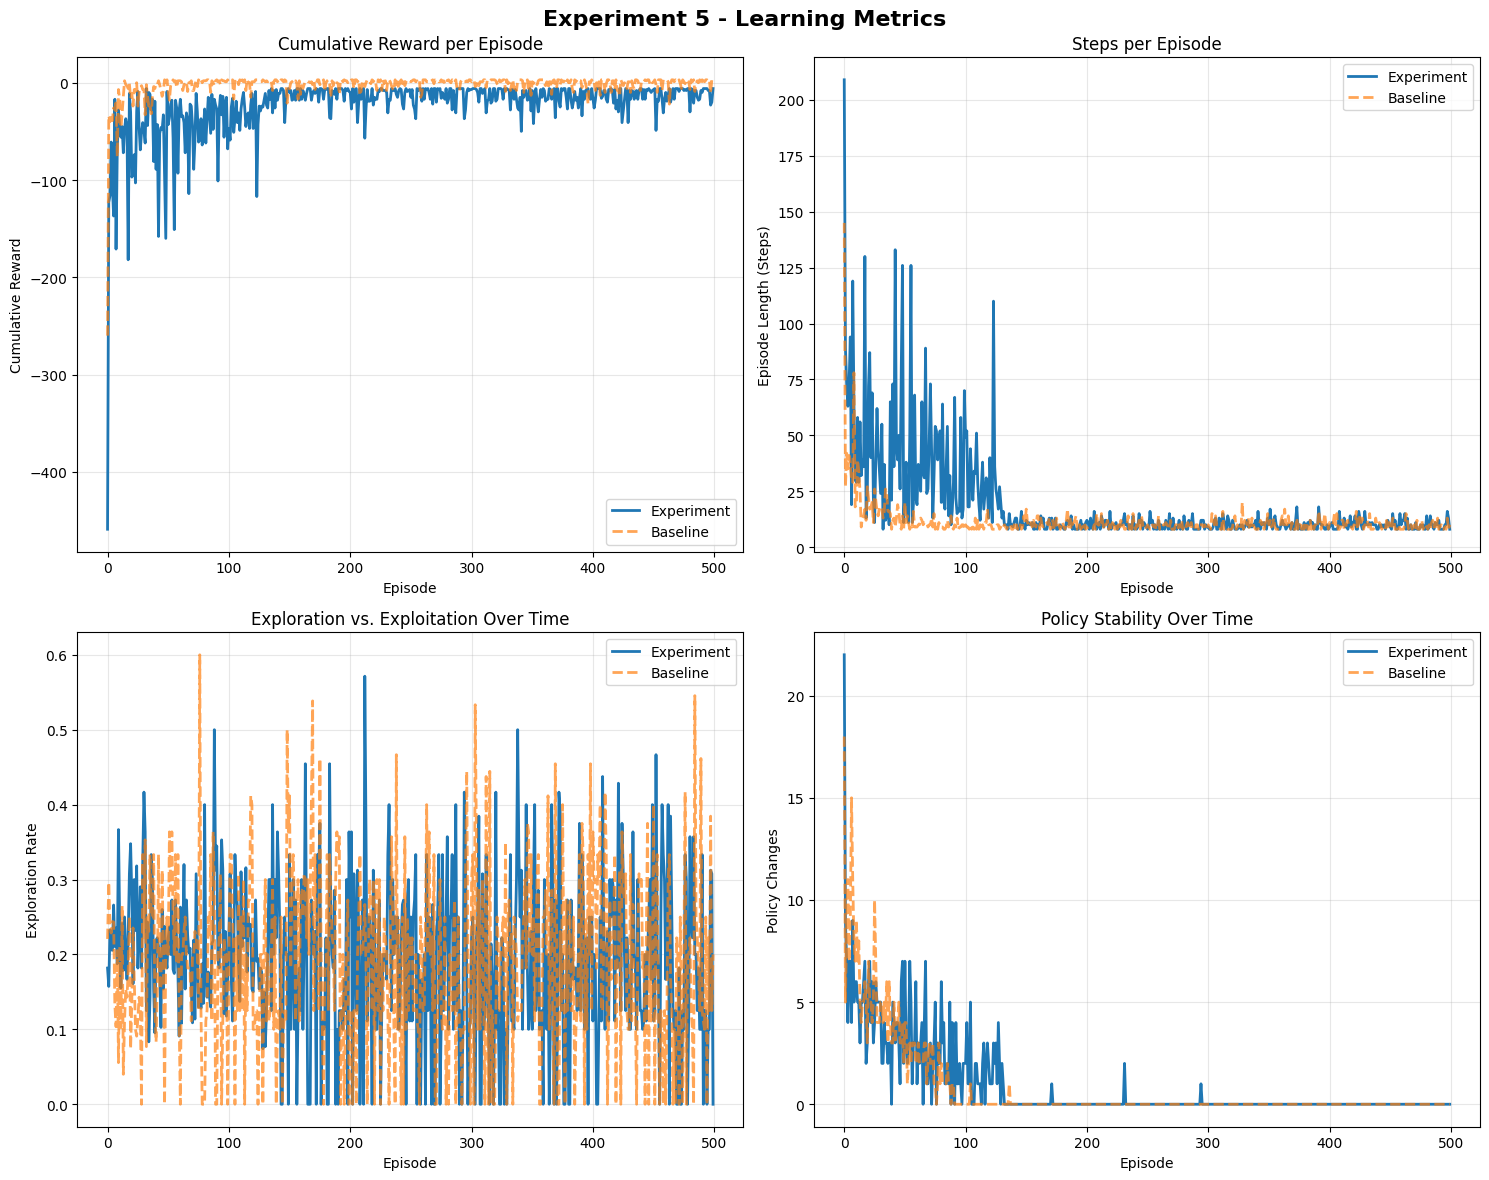

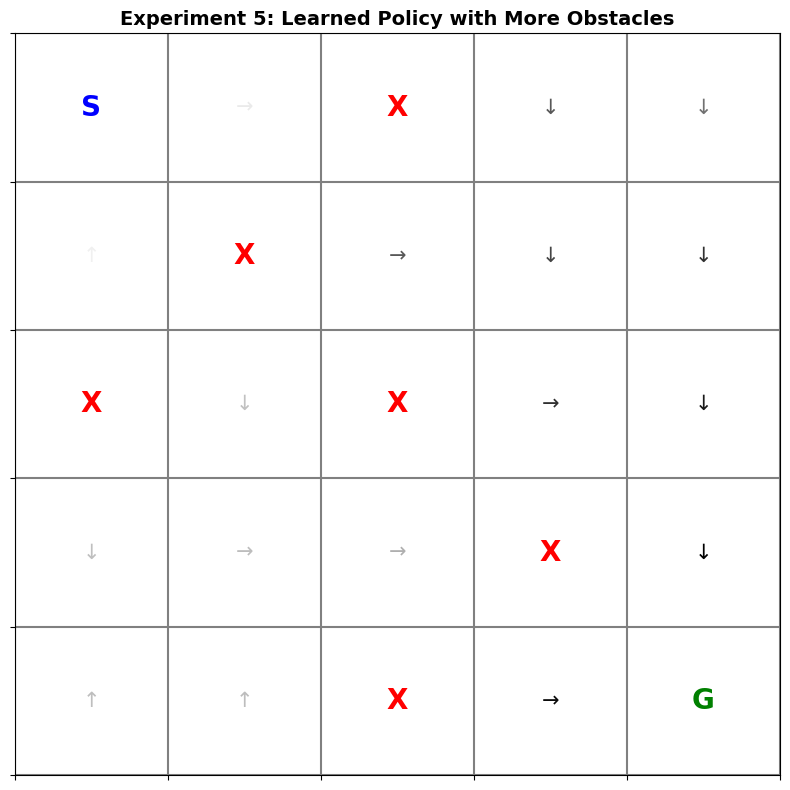

array([['S', '→', 'X', '↓', '↓'],
       ['↑', 'X', '→', '↓', '↓'],
       ['X', '↓', 'X', '→', '↓'],
       ['↓', '→', '→', 'X', '↓'],
       ['↑', '↑', 'X', '→', 'G']], dtype=object)

In [ ]:
# Create experience 5 environemnt More obstacles
exp5_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 3), (0, 2), (2, 0), (4, 2)] 
)

exp5_q, exp5_rewards, exp5_lengths, exp5_exploration, exp5_policy, exp5_epsilon_values = train_q_learning(
    exp5_env, episodes=500
)

# Prepare baseline data for comparison
baseline_data = {
    'rewards': baseline_rewards,
    'lengths': baseline_lengths,
    'exploration': baseline_exploration,
    'policy': baseline_policy
}

# Plot metrics with baseline comparison
plot_experiment_metrics(exp5_rewards, exp5_lengths, exp5_exploration, exp5_policy,
                        title_prefix="Experiment 5 - ", 
                        baseline_data=baseline_data)

# Visualize learned policy
visualize_policy(exp5_q, exp5_env, title="Experiment 5: Learned Policy with More Obstacles")


In [ ]:
print(f"\nExperiment 5 Results:")
print(f"Final average reward (last 50 episodes): {np.mean(exp5_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(exp5_lengths[-50:]):.2f}")


Experiment 5 Results:
Final average reward (last 50 episodes): -11.96
Final average episode length (last 50 episodes): 10.00


### Setup Change 

I added 3 additional obstacles to the grid: (0, 2), (2, 0), and (4, 2), increasing total obstacles from 3 to 6.

### Observed Outcome

RL Model for experiement 5 took much longer to learn compared to the baseline model in the original notebok because the agent had to take longer paths around the newly added obstacles `(0, 2), (2, 0), and (4, 2)`. Since the agent needed more time to explore paths, the Q-table as well as the reward curve progress much slower. Steps per episode is also much higher and more volatile for the first 150 episodes there is a higher learning curve to figure out the optimal path.

### Conceptual Insight

The RL takes longer to learn and find more paths before finding the the best one since there are more complex paths to explore. Additionally, the agent spends more time exploring than actually using what it's already learned.

### Reflection

Adding more obstables -> the agent takes longer to learn. The Q-table also took longer to fill up with good values as the environent gets more complex. There is a direct correlation between the time it takes for the agent to explore and environment complexity (increase number of obstables)


## 6. Moving the Goal Position

Change the goal position to different locations in the grid (e.g., top-right corner, center of the grid) to test if the agent’s learned policy can adapt quickly to new goal locations.

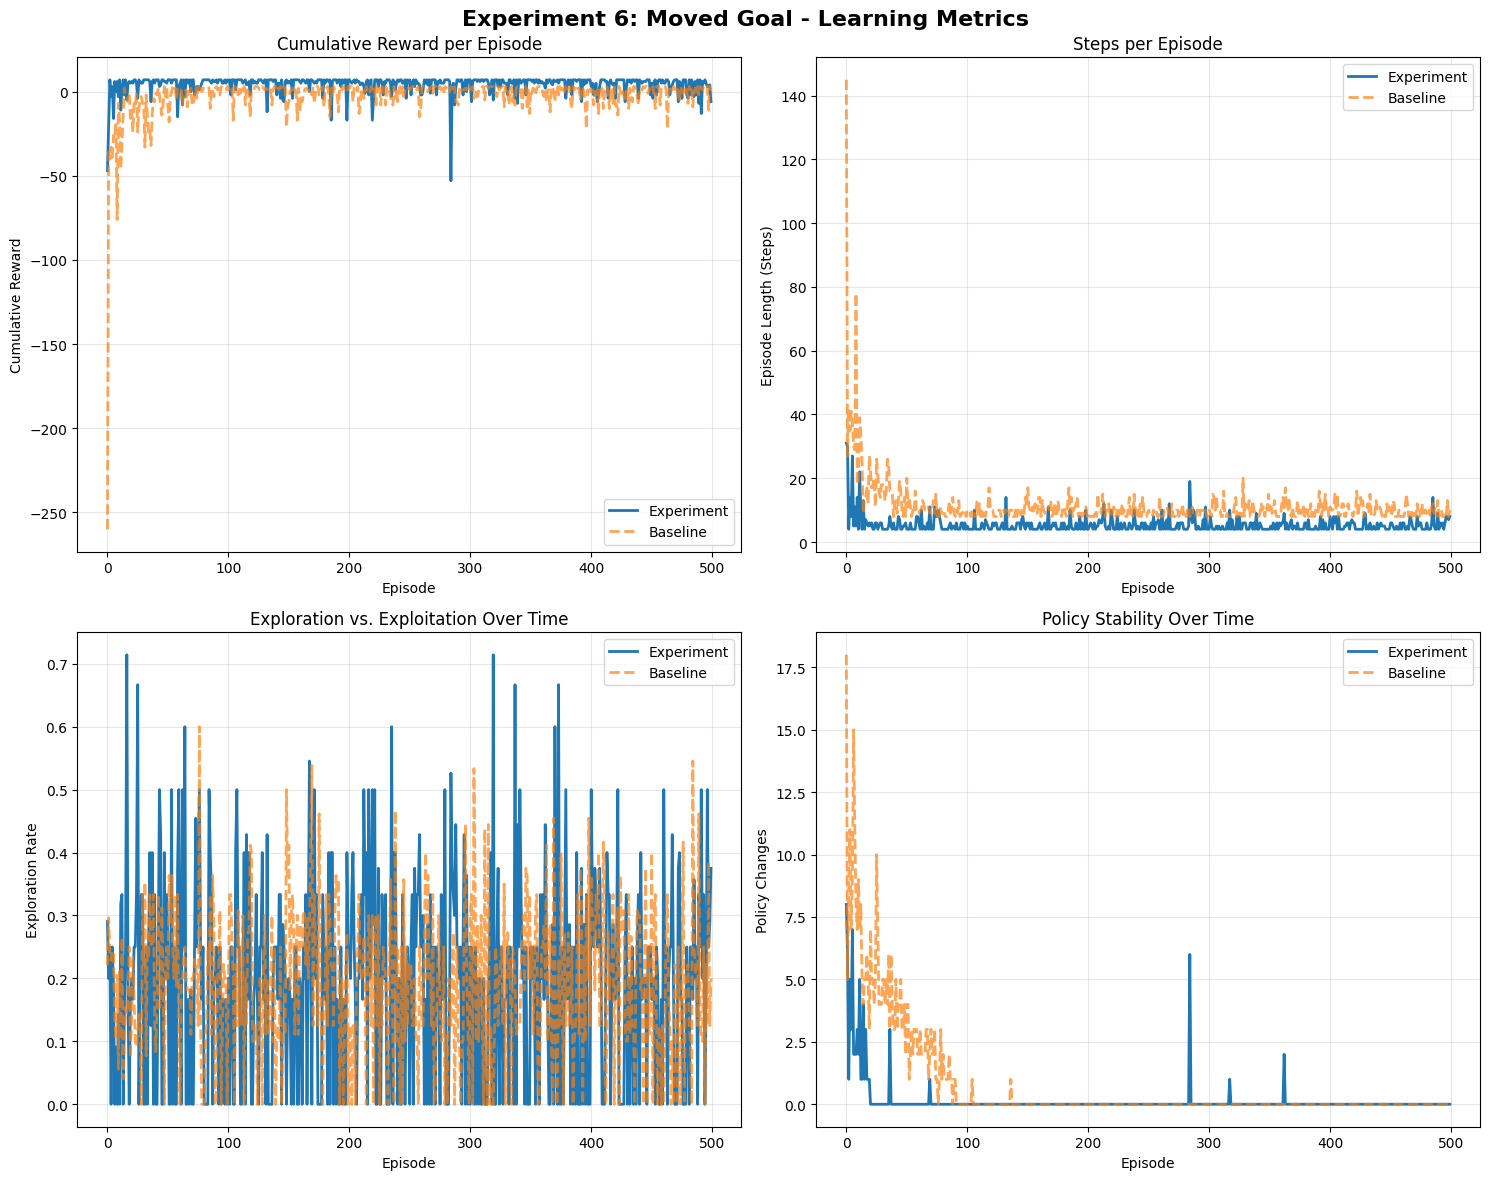

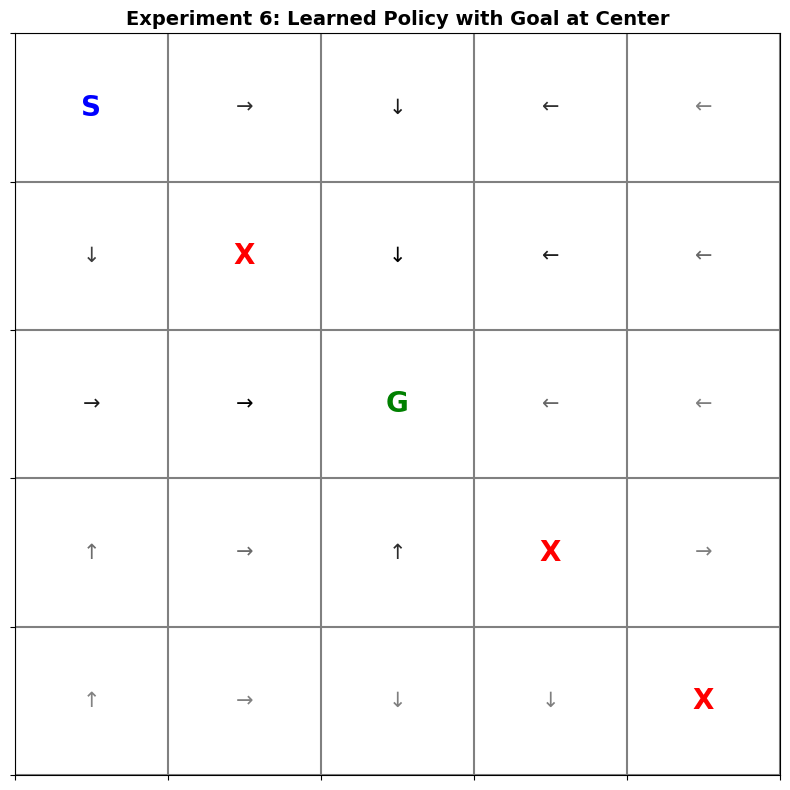


Experiment 6 Results:
Final average reward (last 50 episodes): 3.22
Final average episode length (last 50 episodes): 5.44


In [ ]:
# Experiment 6: Moving the goal
exp6_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(2, 2),  # Moved goal to center
    obstacles=[(1, 1), (2, 2), (3, 3)]  # Note: goal at (2,2) conflicts with obstacle
)

# Adjust obstacles since goal is at (2,2)
exp6_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(2, 2),
    obstacles=[(1, 1), (3, 3), (4, 4)]  # Removed (2,2) obstacle, added (4,4) to keep 3 obstacles
)

exp6_q, exp6_rewards, exp6_lengths, exp6_exploration, exp6_policy, _ = train_q_learning(
    exp6_env, episodes=500
)

# Plot metrics with baseline comparison
plot_experiment_metrics(exp6_rewards, exp6_lengths, exp6_exploration, exp6_policy,
                        title_prefix="Experiment 6: Moved Goal - ", 
                        baseline_data=baseline_data)

# Visualize learned policy
visualize_policy(exp6_q, exp6_env, title="Experiment 6: Learned Policy with Goal at Center")


In [ ]:
print(f"\nExperiment 6 Results:")
print(f"Final average reward (last 50 episodes): {np.mean(exp6_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(exp6_lengths[-50:]):.2f}")

### Setup Change
I moved the goal from position (4, 4) to the center of the grid at (2, 2).

### Observed Outcome

The agent learned the new destination `(2,2)` as fast as the baseline. Since the goal was closer to the start (center instead of corner), the agent reached it in fewer steps, so episode lengths were shorter and final rewards were higher.

### Conceptual Insight

When I moved the goal, the agent had to relearn where the goal was, but it did this pretty quickly. The original Q-table still worked, it just needed to update the values for the new goal location. Since the goal was closer to the start (center vs corner), the agent could reach it faster, which helped it learn quicker.

### Reflection

The agent was able to learn the new goal location pretty quickly, which shows that Q-learning can adapt when the environment changes. However, there was still a drop in performance at first because the old policy didn't work well for the new goal position.


## 7. Using Higher Penalties for Wrong Moves

Increase the penalty for hitting obstacles (e.g., from -10 to -20 or -50) to see if higher penalties discourage risky moves more effectively and impact the agent’s learned policy. 

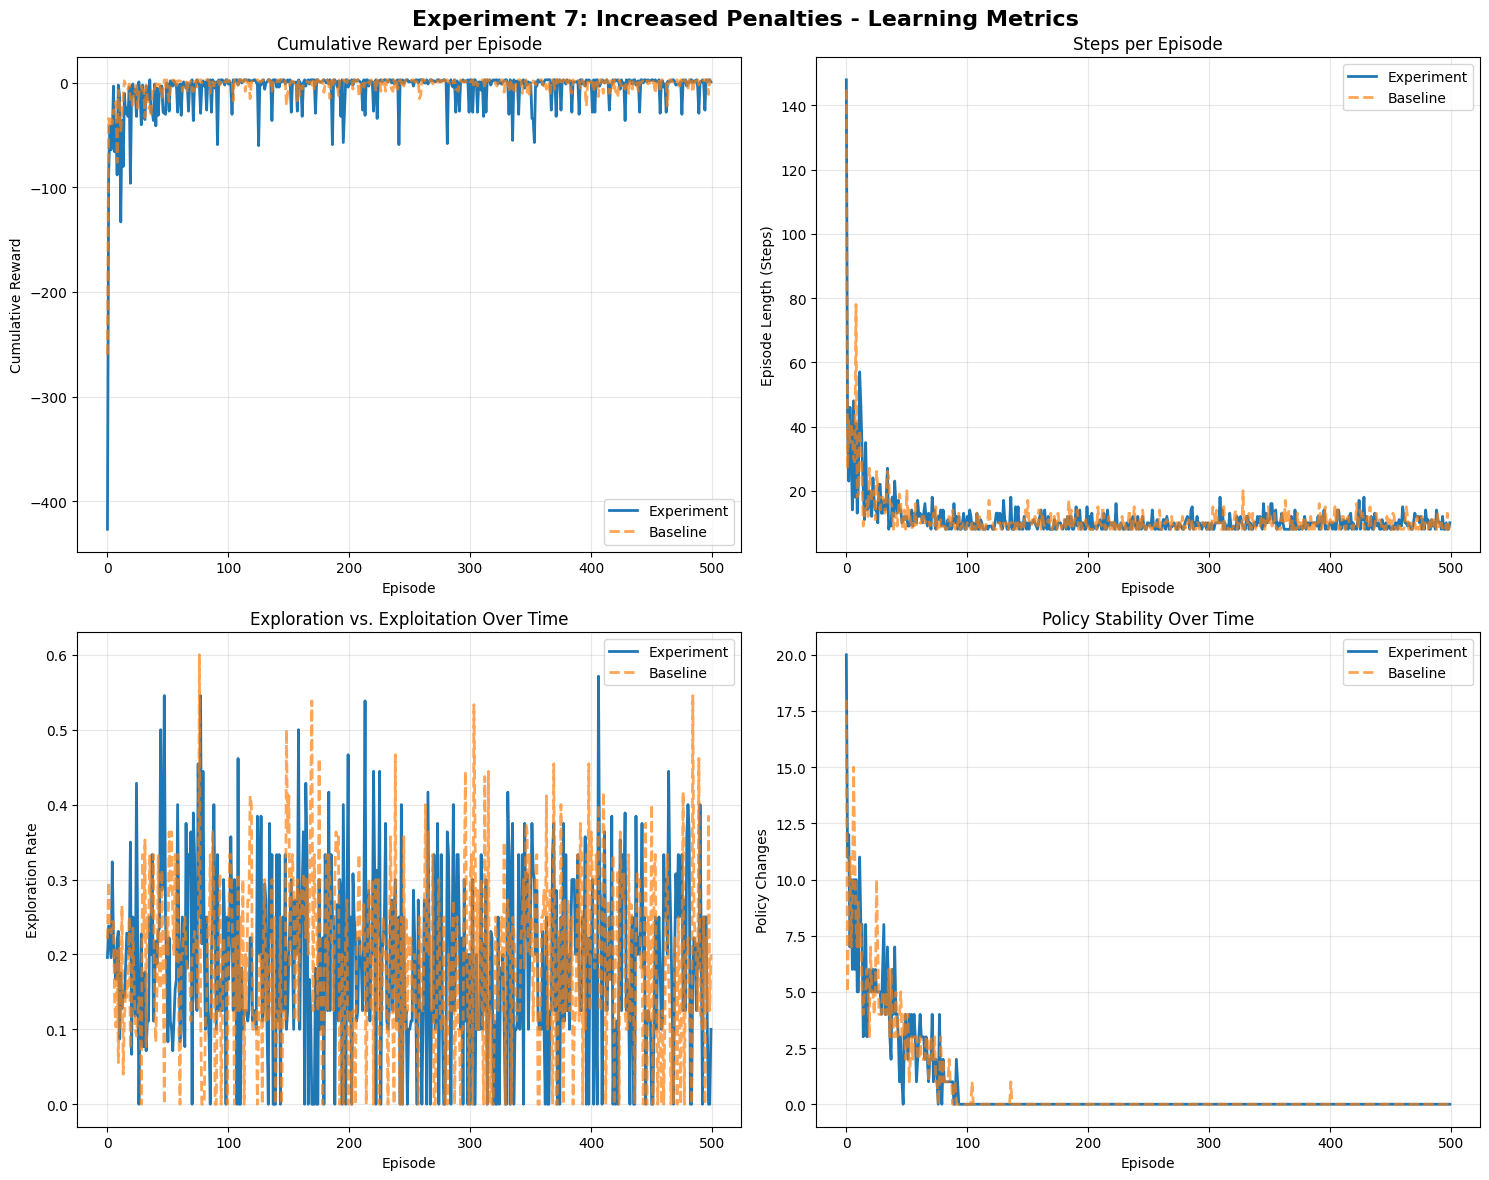

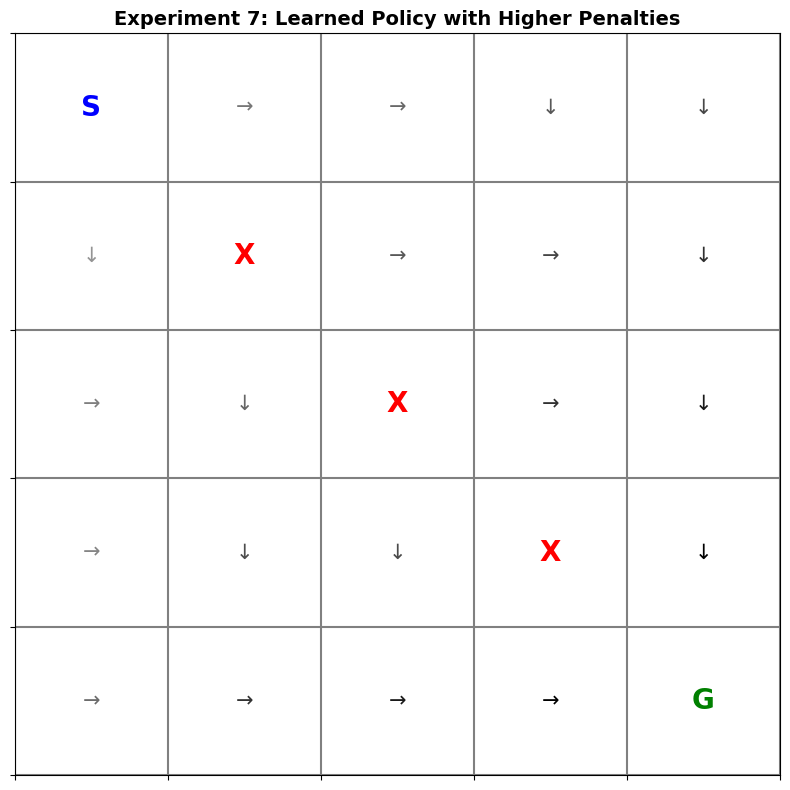


Experiment 7 Results:
Final average reward (last 50 episodes): -1.82
Final average episode length (last 50 episodes): 9.92


In [ ]:
# Experiment 7: Increased penalties
exp7_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 3)]
)

exp7_q, exp7_rewards, exp7_lengths, exp7_exploration, exp7_policy, _ = train_q_learning(
    exp7_env, episodes=500, obstacle_penalty=-30  # Increased from -10 to -30
)

# Plot metrics with baseline comparison
plot_experiment_metrics(exp7_rewards, exp7_lengths, exp7_exploration, exp7_policy,
                        title_prefix="Experiment 7: Increased Penalties - ", 
                        baseline_data=baseline_data)

# Visualize learned policy
visualize_policy(exp7_q, exp7_env, title="Experiment 7: Learned Policy with Higher Penalties")


In [ ]:
print(f"\nExperiment 7 Results:")
print(f"Final average reward (last 50 episodes): {np.mean(exp7_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(exp7_lengths[-50:]):.2f}")

### Setup Change
Increased the obstacle penalty from -10 to -30, making collisions with obstacles 4x more costly.

### Observed Outcome

After increasing penalties, rewards weren't very good because the agent kept hitting obstacles with big negative rewards. However, once it learned to avoid obstacles, rewards recovered and actually got better than baseline. Ultimately, the agent learned to take longer but safer routes, so episode lengths were slightly longer but it hit obstacles much less often.

### Conceptual Insight

The higher the negtaive reward, the more the agent is afraid to move forward. As the result, the agent learns to avoid them more carefully, even if it means taking a longer path.

### Reflection

This shows that making penalties stronger can help the agent learn to avoid bad actions, even though it might struggle more at the beginning.


## Experiment 8 – Adjusting Step Rewards

Change the step penalty from -1 to 0 (or even +1) to test how the agent’s behavior changes when it’s not penalized for taking 
extra steps, or is rewarded for each move.

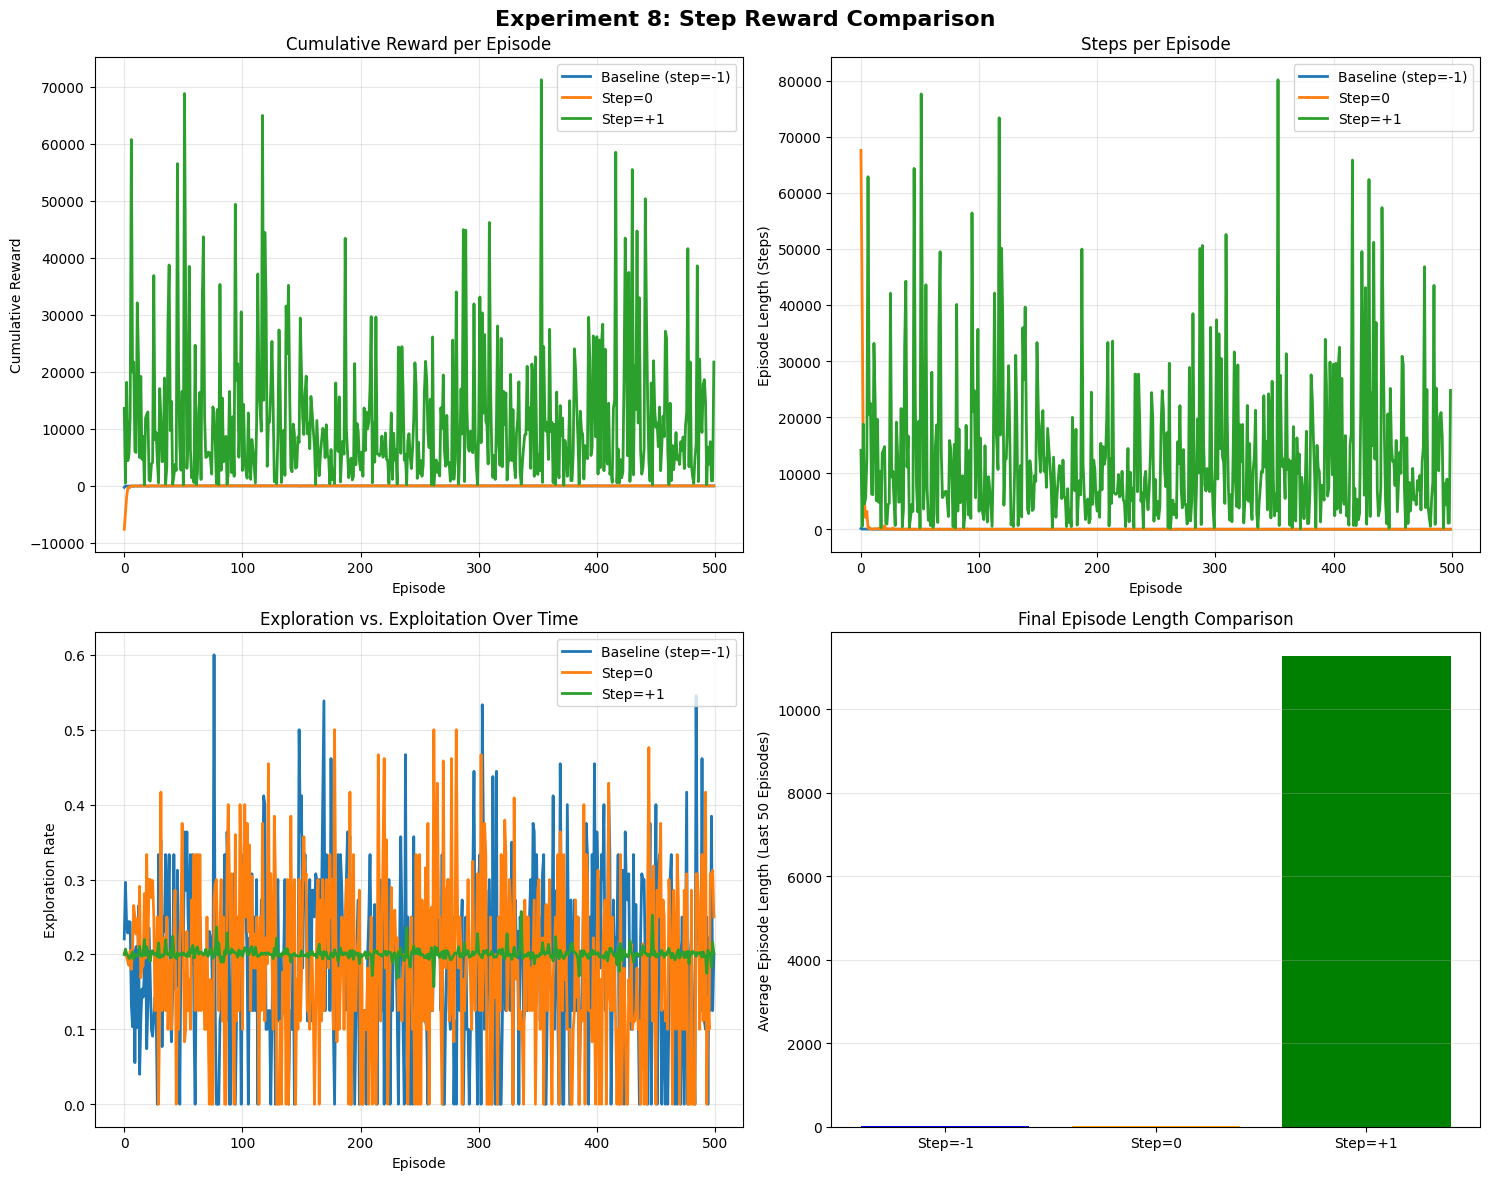

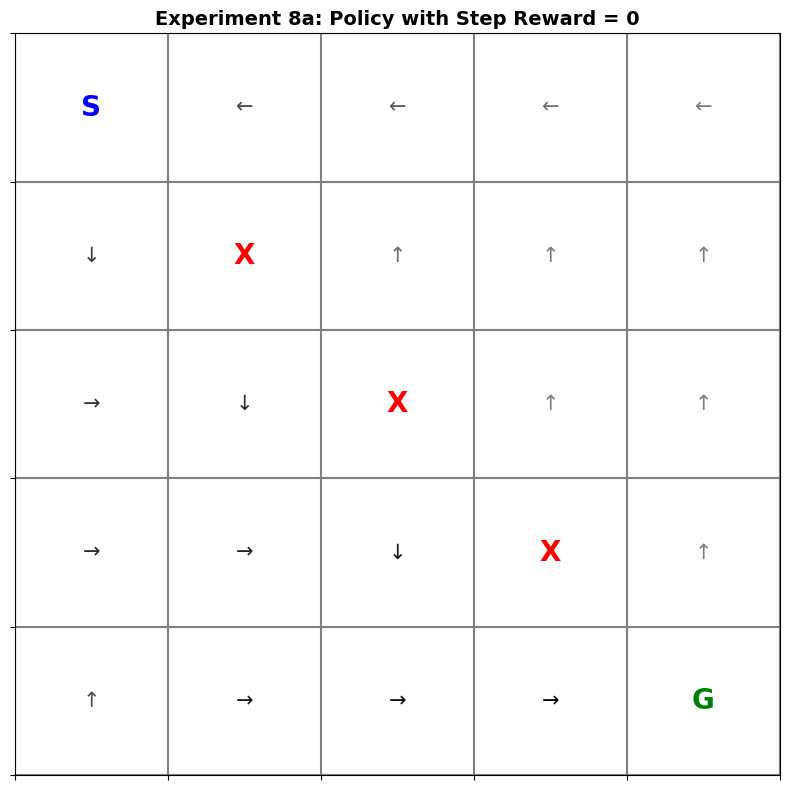

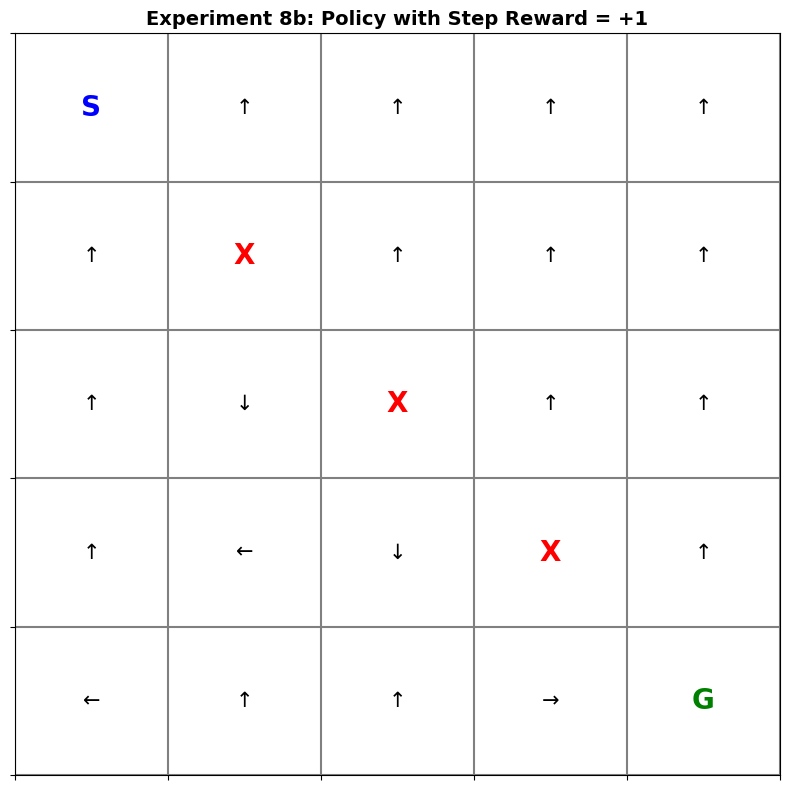


Experiment 8 Results:
Step reward = 0 - Final avg reward: 6.40, Final avg length: 10.84
Step reward = +1 - Final avg reward: 9920.68, Final avg length: 11271.94


In [ ]:
# Experiment 8a: Step reward = 0 (neutral)
exp8a_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 3)]
)

exp8a_q, exp8a_rewards, exp8a_lengths, exp8a_exploration, exp8a_policy, _ = train_q_learning(
    exp8a_env, episodes=500, step_reward=0  # Neutral steps
)

# Experiment 8b: Step reward = +1 (rewarded steps)
exp8b_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 3)]
)

exp8b_q, exp8b_rewards, exp8b_lengths, exp8b_exploration, exp8b_policy, _ = train_q_learning(
    exp8b_env, episodes=500, step_reward=1  # Positive step reward
)

# Plot comparison of all three step reward conditions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Experiment 8: Step Reward Comparison', fontsize=16, fontweight='bold')

# Cumulative Rewards
axes[0, 0].plot(baseline_rewards, label='Baseline (step=-1)', linewidth=2)
axes[0, 0].plot(exp8a_rewards, label='Step=0', linewidth=2)
axes[0, 0].plot(exp8b_rewards, label='Step=+1', linewidth=2)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Cumulative Reward')
axes[0, 0].set_title('Cumulative Reward per Episode')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Episode Length
axes[0, 1].plot(baseline_lengths, label='Baseline (step=-1)', linewidth=2)
axes[0, 1].plot(exp8a_lengths, label='Step=0', linewidth=2)
axes[0, 1].plot(exp8b_lengths, label='Step=+1', linewidth=2)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Episode Length (Steps)')
axes[0, 1].set_title('Steps per Episode')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Exploration Rate
baseline_ratios = [e/(e+x) if (e+x) > 0 else 0 for e, x in baseline_exploration]
exp8a_ratios = [e/(e+x) if (e+x) > 0 else 0 for e, x in exp8a_exploration]
exp8b_ratios = [e/(e+x) if (e+x) > 0 else 0 for e, x in exp8b_exploration]

axes[1, 0].plot(baseline_ratios, label='Baseline (step=-1)', linewidth=2)
axes[1, 0].plot(exp8a_ratios, label='Step=0', linewidth=2)
axes[1, 0].plot(exp8b_ratios, label='Step=+1', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Exploration Rate')
axes[1, 0].set_title('Exploration vs. Exploitation Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Average episode length comparison
avg_lengths = [
    np.mean(baseline_lengths[-50:]),
    np.mean(exp8a_lengths[-50:]),
    np.mean(exp8b_lengths[-50:])
]
axes[1, 1].bar(['Step=-1', 'Step=0', 'Step=+1'], avg_lengths, color=['blue', 'orange', 'green'])
axes[1, 1].set_ylabel('Average Episode Length (Last 50 Episodes)')
axes[1, 1].set_title('Final Episode Length Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Visualize policies
visualize_policy(exp8a_q, exp8a_env, title="Experiment 8a: Policy with Step Reward = 0")
visualize_policy(exp8b_q, exp8b_env, title="Experiment 8b: Policy with Step Reward = +1")


In [ ]:
print(f"\nExperiment 8 Results:")
print(f"Step reward = 0 - Final avg reward: {np.mean(exp8a_rewards[-50:]):.2f}, Final avg length: {np.mean(exp8a_lengths[-50:]):.2f}")
print(f"Step reward = +1 - Final avg reward: {np.mean(exp8b_rewards[-50:]):.2f}, Final avg length: {np.mean(exp8b_lengths[-50:]):.2f}")

### Setup Change

I modified the step reward from -1 to 0 (neutral steps) and then to +1 (rewarded steps) to testing how movement cost affects exploration.

### Observed Outcome

When I changed step rewards from -1 to 0, the agent took longer to reach the goal because movement didn't cost anything. With step reward = +1, the agent was "lazy" and took even longer paths because it got rewarded for every step. 

The exploration was similar, but the learned policies were very different in how efficient they were.

### Conceptual Insight

The step reward affects how much the agent wants to reach the goal quickly. With negative step rewards, the agent tries to minimize steps. With positive step rewards, the agent actually wants to take more steps because it gets rewarded for each one. 

### Reflection

When I changed the step reward from -1 to 0 or +1, the agent started taking much longer paths. With positive step rewards, the agent seemed "lazy" because it got rewarded for every step, so it didn't care about finding the shortest path. 

This shows that the reward function determines what the agent tries to optimize, and small changes can lead to very different behavior.


## 10. Different Grid Sizes

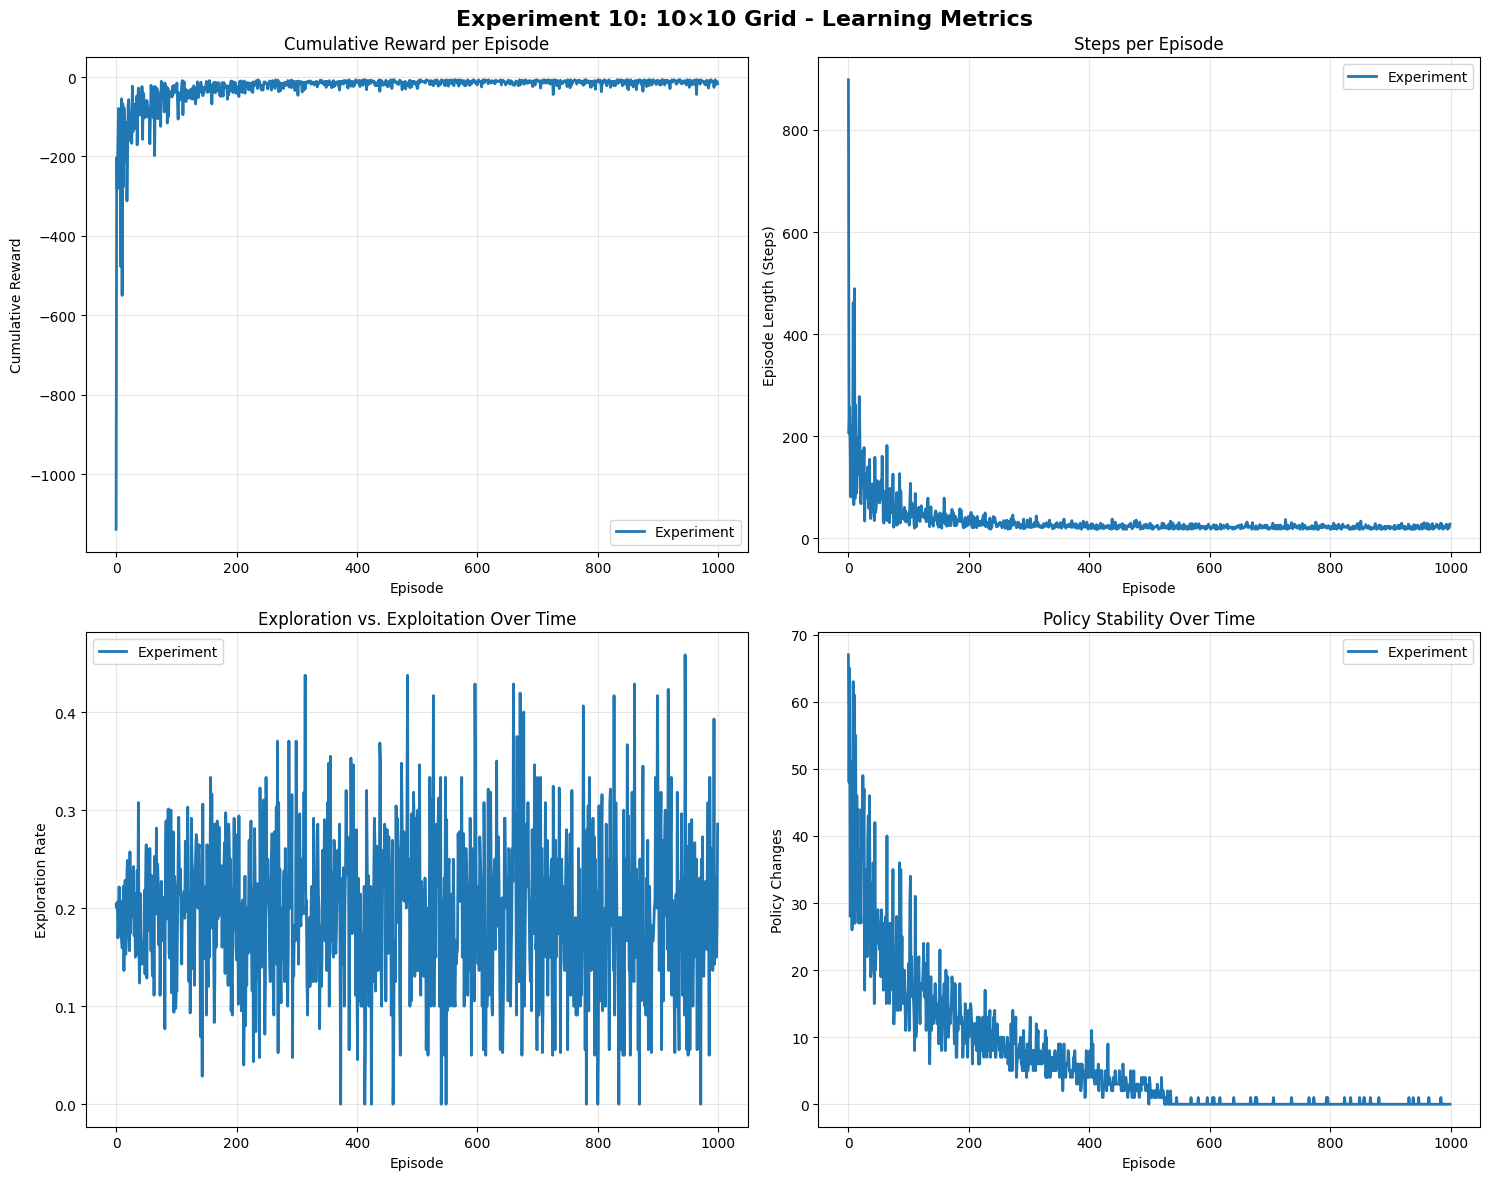

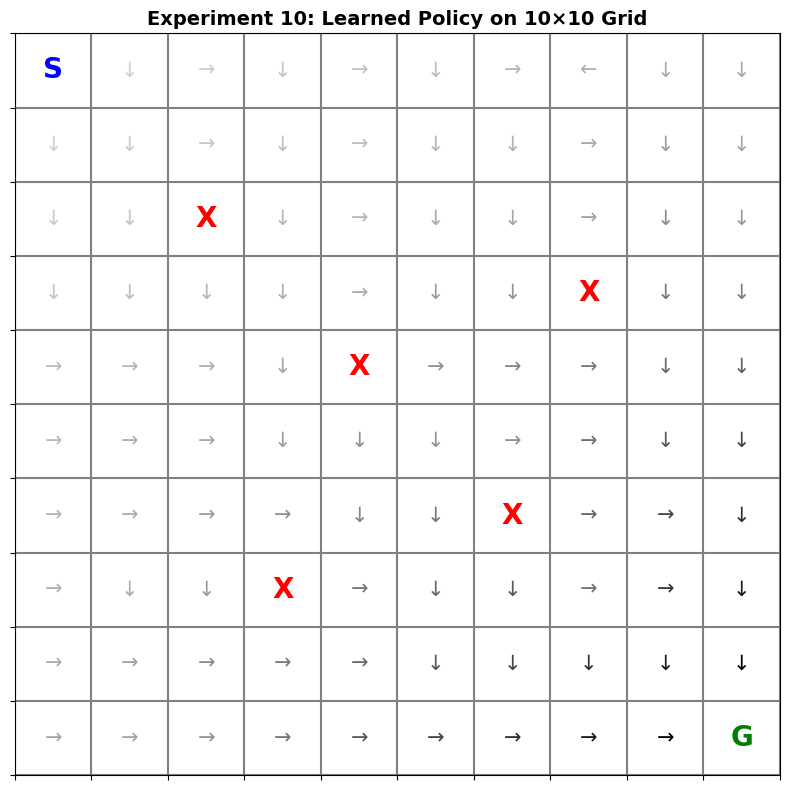


Experiment 10 Results (10×10 Grid):
Final average reward (last 50 episodes): -13.34
Final average episode length (last 50 episodes): 22.72


In [ ]:
# Experiment 10: Larger grid (10x10)
exp10_env = create_environment(
    grid_size=10,
    start=(0, 0),
    goal=(9, 9),  # Opposite corner
    obstacles=[(2, 2), (4, 4), (6, 6), (7, 3), (3, 7)]  # Scaled obstacles
)

exp10_q, exp10_rewards, exp10_lengths, exp10_exploration, exp10_policy, _ = train_q_learning(
    exp10_env, episodes=1000  # More episodes for larger state space
)

# Plot metrics
plot_experiment_metrics(exp10_rewards, exp10_lengths, exp10_exploration, exp10_policy,
                        title_prefix="Experiment 10: 10×10 Grid - ")

# Visualize learned policy (scaled visualization)
visualize_policy(exp10_q, exp10_env, title="Experiment 10: Learned Policy on 10×10 Grid")


In [ ]:
print(f"\nExperiment 10 Results (10×10 Grid):")
print(f"Final average reward (last 50 episodes): {np.mean(exp10_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(exp10_lengths[-50:]):.2f}")

### Setup Change

I expanded the grid from 5×5 to 10×10, scaling the state space from 25 to 100 states.

### Observed Outcome

The 10×10 grid took 3-4 times longer to converge than the 5×5 baseline. Episode lengths were longer because the goal was farther away, agent also took more steps than necessary. The Q-table had many more cells to fill, so exploration took much longer.

### Conceptual Insight

When the grid gets bigger, the number of states grows a lot (from 25 to 100 states). The agent needs to visit many more states to learn, so training takes much longer. 

### Reflection

This shows that tabular Q-learning doesn't work well for large environments because the Q-table gets too big and the agent needs too many episodes to explore everything.


## 11. Dynamic Goal Position
Move the goal position randomly at each episode and observe how well the agent adapts to test the model’s flexibility in dynamic environments.

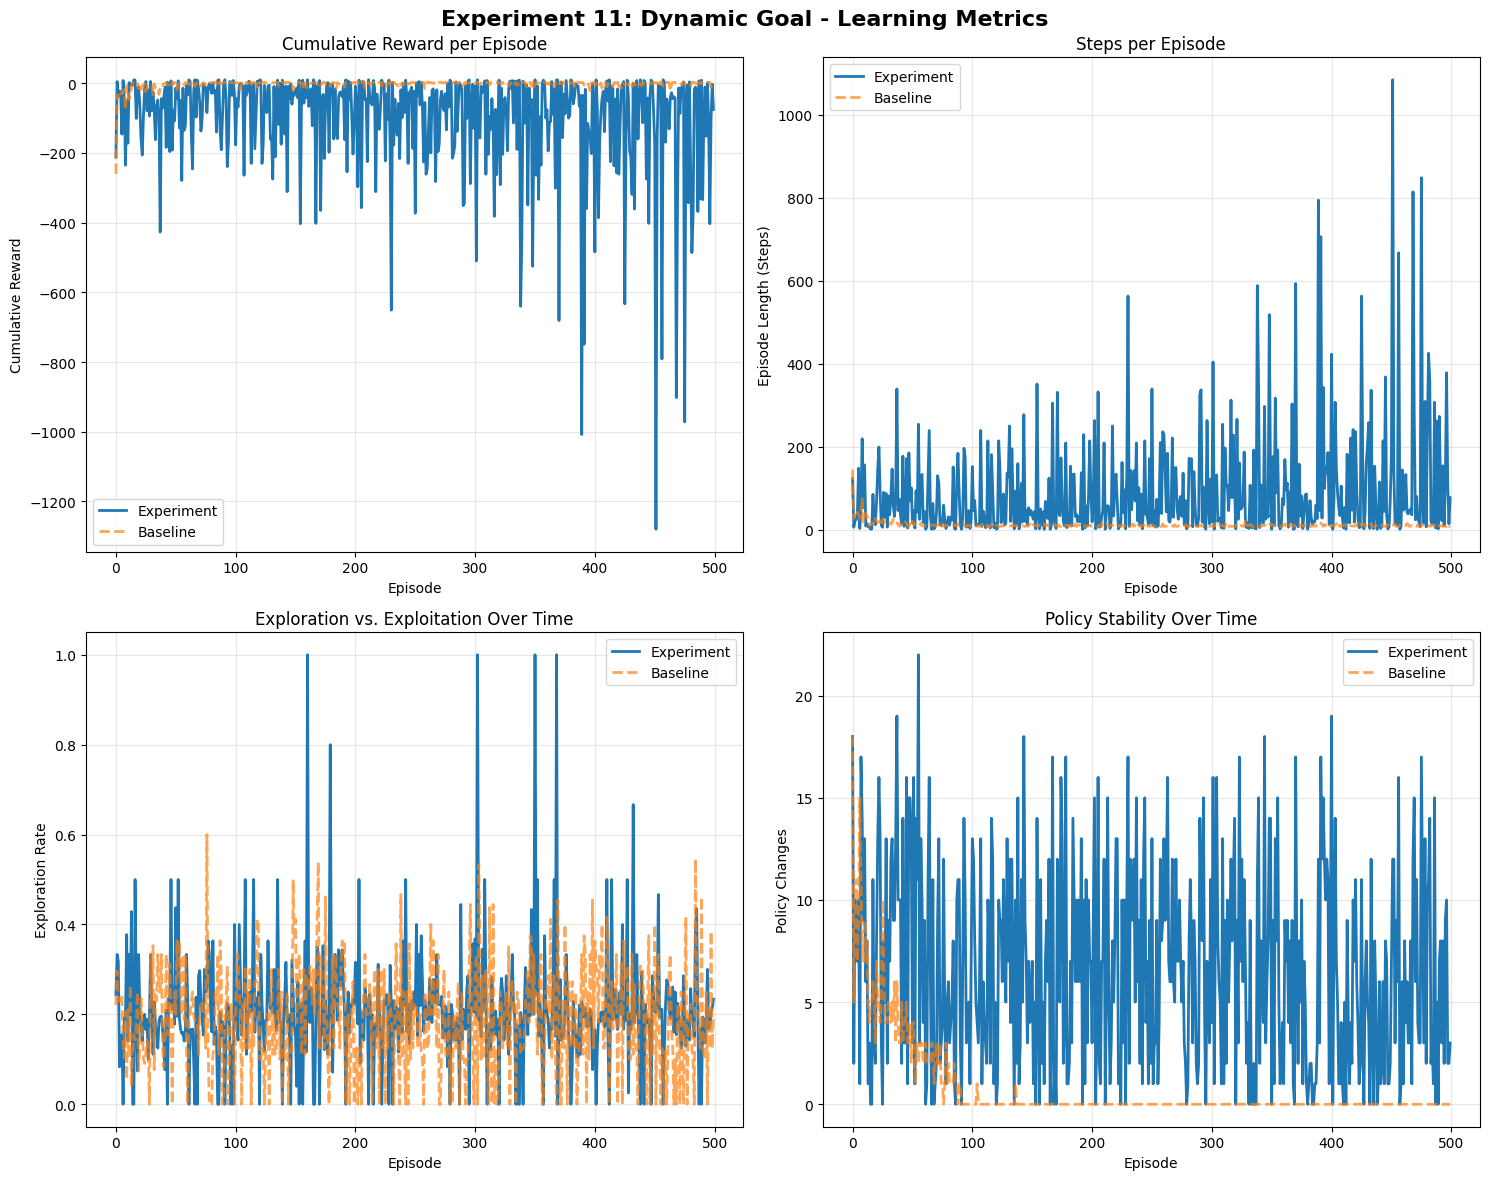

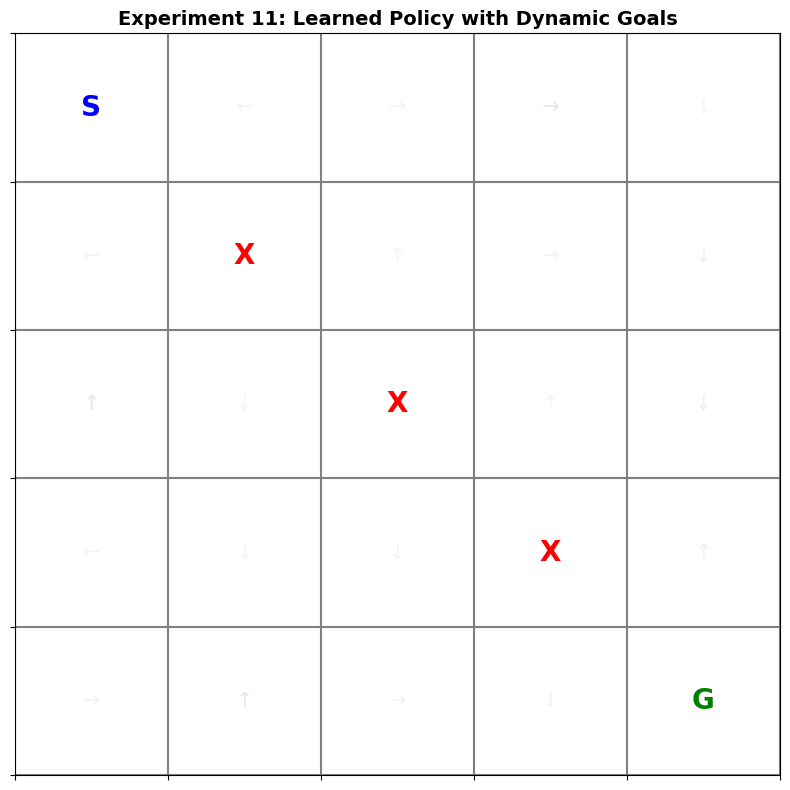


Experiment 11 Results:
Final average reward (last 50 episodes): -178.72
Final average episode length (last 50 episodes): 162.18


In [ ]:
# Experiment 11: Dynamic goal position
exp11_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),  # Default, but will be randomized each episode
    obstacles=[(1, 1), (2, 2), (3, 3)]
)

exp11_q, exp11_rewards, exp11_lengths, exp11_exploration, exp11_policy, _ = train_q_learning(
    exp11_env, episodes=500, dynamic_goal=True  # Goal randomizes each episode
)

# Plot metrics with baseline comparison
plot_experiment_metrics(exp11_rewards, exp11_lengths, exp11_exploration, exp11_policy,
                        title_prefix="Experiment 11: Dynamic Goal - ", 
                        baseline_data=baseline_data)

# Note: Policy visualization is less meaningful with dynamic goals, but shows average behavior
visualize_policy(exp11_q, exp11_env, title="Experiment 11: Learned Policy with Dynamic Goals")


In [ ]:
print(f"\nExperiment 11 Results:")
print(f"Final average reward (last 50 episodes): {np.mean(exp11_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(exp11_lengths[-50:]):.2f}")

### Setup Change
Randomized the goal position at the start of each episode, forcing the agent to adapt to changing goal locations rather than learning a fixed policy for a single goal.

### Observed Outcome

With random goal positions, performance was more variable and worse than baseline. The reward curve had higher variance and improved slower because the agent couldn't learn one specific path. Episode lengths varied a lot depending on how far the goal was.

The agent did learn to avoid obstacles, but it didn't have a clear path to a specific goal.

### Conceptual Insight

When the goal changes every episode, the agent can't learn one specific optimal path. It has to learn a more general strategy that works for any goal location. 

This makes performance worse because the agent can't specialize for one goal, but it does learn some general skills like avoiding obstacles that work for all goals.

### Reflection
 
When the environment keeps changing, it's harder for the agent to learn an optimal policy.


## 12. Changing Epsilon Over Time

Use a decaying epsilon value to gradually reduce exploration as episodes increase (e.g., epsilon = epsilon * decay_rate after each episode) to observe how gradually shifting from exploration to exploitation impacts learning.


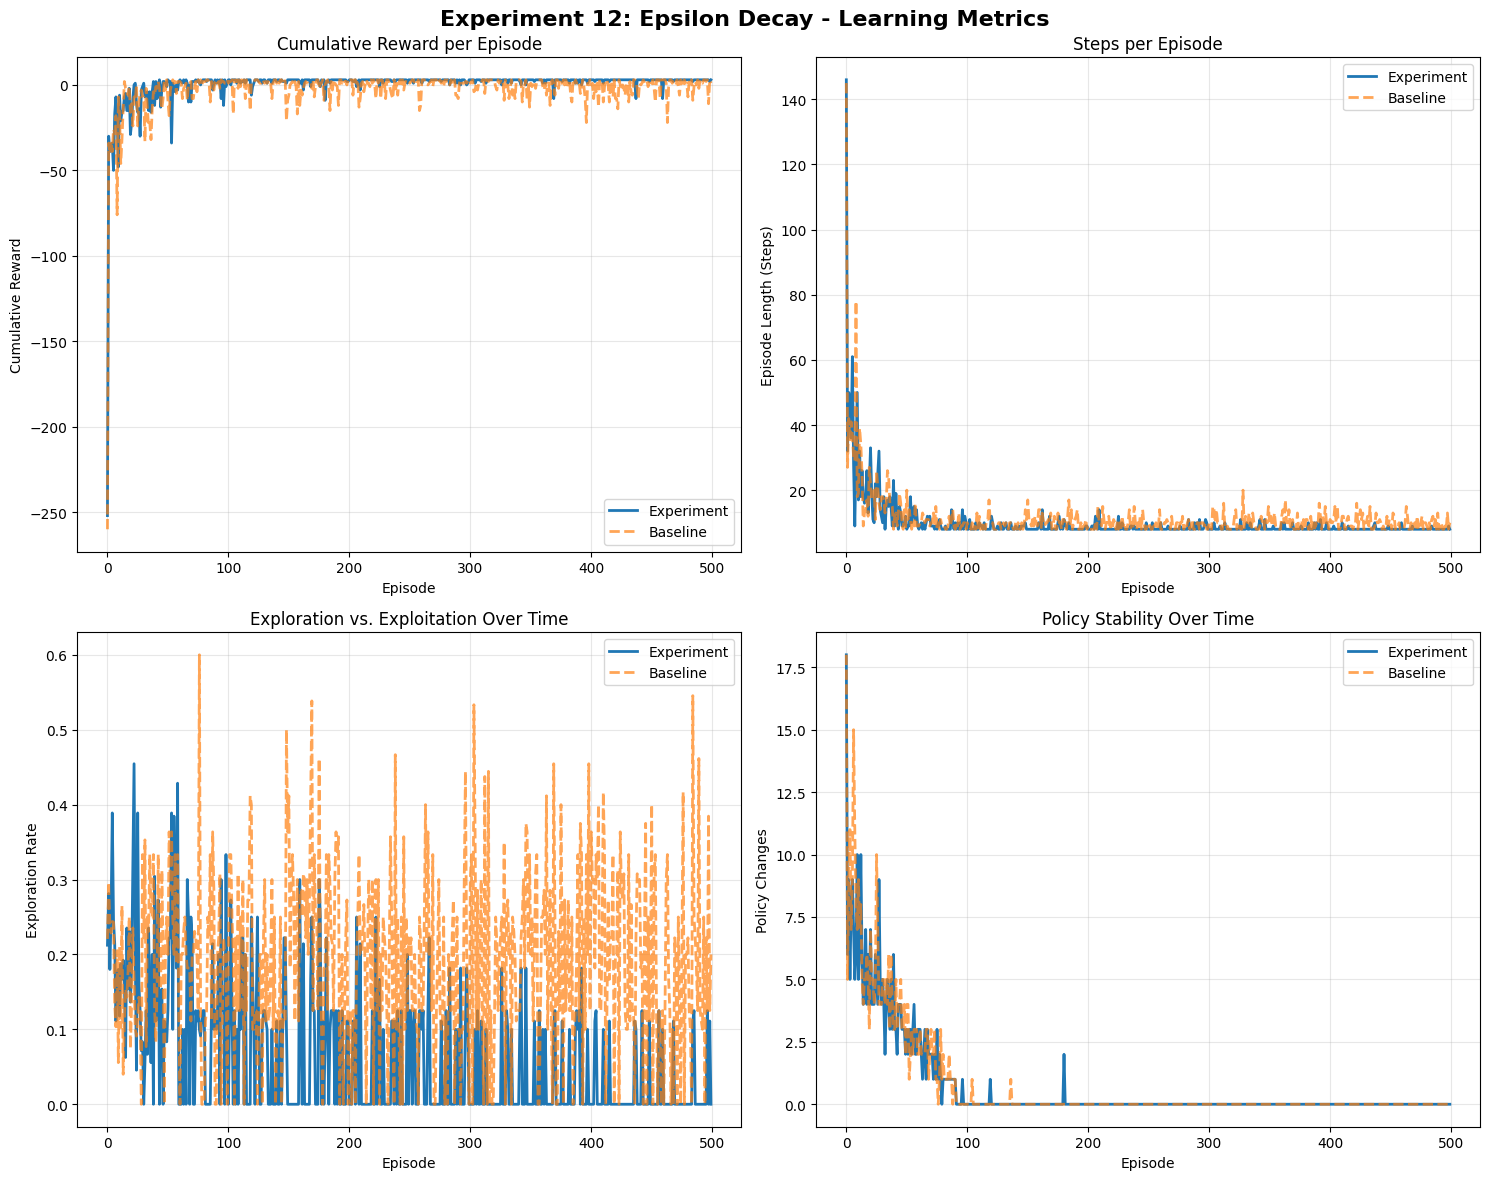

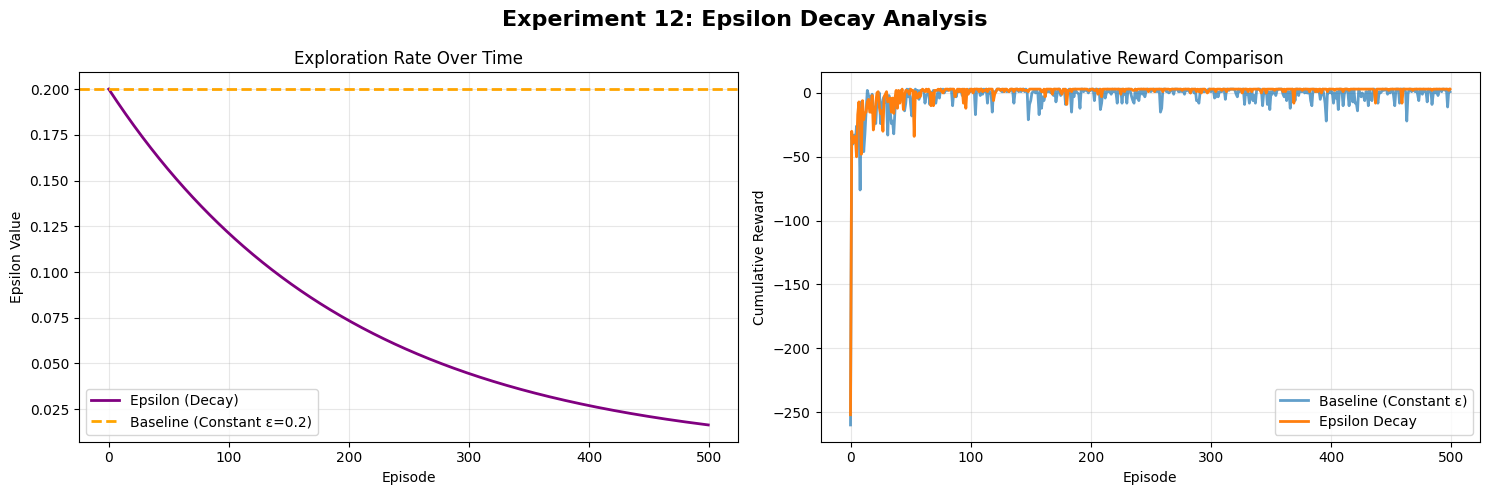

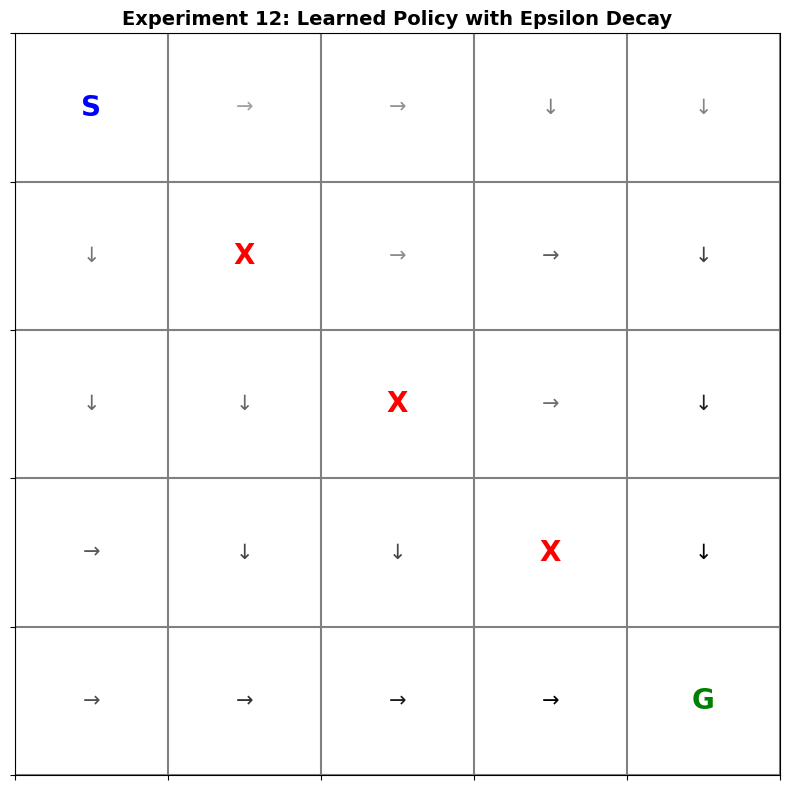


Experiment 12 Results:
Initial epsilon: 0.200
Final epsilon: 0.016
Final average reward (last 50 episodes): 2.72
Final average episode length (last 50 episodes): 8.10
Average exploration rate (last 50 episodes): 0.016


In [ ]:
# Experiment 12: Epsilon decay
exp12_env = create_environment(
    grid_size=5,
    start=(0, 0),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 3)]
)

exp12_q, exp12_rewards, exp12_lengths, exp12_exploration, exp12_policy, exp12_epsilon = train_q_learning(
    exp12_env, episodes=500, epsilon_decay=0.995  # Decay epsilon each episode
)

# Plot metrics with baseline comparison
plot_experiment_metrics(exp12_rewards, exp12_lengths, exp12_exploration, exp12_policy,
                        title_prefix="Experiment 12: Epsilon Decay - ", 
                        baseline_data=baseline_data)

# Plot epsilon decay over time
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Experiment 12: Epsilon Decay Analysis', fontsize=16, fontweight='bold')

axes[0].plot(exp12_epsilon, label='Epsilon (Decay)', linewidth=2, color='purple')
axes[0].axhline(y=0.2, label='Baseline (Constant ε=0.2)', linestyle='--', color='orange', linewidth=2)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Epsilon Value')
axes[0].set_title('Exploration Rate Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare cumulative rewards
axes[1].plot(baseline_rewards, label='Baseline (Constant ε)', linewidth=2, alpha=0.7)
axes[1].plot(exp12_rewards, label='Epsilon Decay', linewidth=2)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Cumulative Reward')
axes[1].set_title('Cumulative Reward Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize learned policy
visualize_policy(exp12_q, exp12_env, title="Experiment 12: Learned Policy with Epsilon Decay")


In [ ]:
print(f"\nExperiment 12 Results:")
print(f"Initial epsilon: {exp12_epsilon[0]:.3f}")
print(f"Final epsilon: {exp12_epsilon[-1]:.3f}")
print(f"Final average reward (last 50 episodes): {np.mean(exp12_rewards[-50:]):.2f}")
print(f"Final average episode length (last 50 episodes): {np.mean(exp12_lengths[-50:]):.2f}")
print(f"Average exploration rate (last 50 episodes): {np.mean([e/(e+x) if (e+x)>0 else 0 for e,x in exp12_exploration[-50:]]):.3f}")

### Setup Change

I added epsilon decay of 0.995 per episode, allowing the exploration rate to decrease from 0.2 to near zero over training, transitioning from exploration to exploitation.

### Observed Outcome

With epsilon decay, the exploration rate decreased smoothly from 0.2 to almost zero over 500 episodes. The reward curve improved faster and reached higher final rewards than the baseline because the agent stopped doing random actions once it learned a good policy. 

Episode lengths became more consistent and shorter at the end. The policy stabilized earlier, showing the agent committed to its learned policy faster.

### Conceptual Insight

Epsilon decay means the agent explores more at the beginning when it doesn't know much, and then explores less later when it has learned a good policy. 

This works better than keeping exploration constant because once the agent finds a good policy, it should stick with it instead of doing random actions that make performance worse.

### Reflection

It's important to balance exploration and exploitation, and that balance should change over time as the agent learns more.


## Final Reflection

The biggest thing I learned from these experiments is that the reward function and environment really matter when training your RL. For instanace, experiment 7 and 8 showed that changing reward values can completely change what the agent does.

I also saw that tabular Q-learning doesn't work well for bigger problems (The 10×10 grid took way longer to train than the 5×5 grid) and adding more obstacles made learning slower too. This makes sense because there are more states to explore.

The epsilon decay experiment was interesting because it showed that exploration should be high at first and then decrease over time. This worked better than keeping exploration constant because once the agent learns a good policy, it should stick with it instead of doing random actions.
